<a href="https://colab.research.google.com/github/xper100/AIBootCamp-Project/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# import sys
# if 'google.colab' in sys.modules:
!pip install pdpbox
!pip install category_encoders
!pip install pandas-profiling
!pip install plotly
!pip install sklearn
!pip install eli5
!pip install shap
!pip install xgboost
!pip install scikit-learn  -U

## install Lightgbm in Mac
# pip uninstall lightgbm
# git clone --recursive https://github.com/Microsoft/LightGBM ; cd LightGBM
# export CXX=g++-8 CC=gcc-8

!pip install lightgbm
# catboost and visualization 
!pip install catboost
!pip install ipywidgets

!pip install tensorflow

  Using cached matplotlib-3.1.1-cp38-cp38-macosx_10_9_x86_64.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.0.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
  Using cached matplotlib-3.4.2-cp38-cp38-macosx_10_9_x86_64.whl (7.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.2 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy.stats import randint, uniform

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import xgboost as xgb
import lightgbm as lgb

# save model
import pickle # The pickle API for serializing standard Python objects.
import joblib # The joblib API for efficiently serializing Python objects with NumPy arrays

# 1. 데이터 업로드

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os 
working_drectory = os.getcwd()
print(working_drectory)

/Users/xper100


In [ ]:
import pandas as pd
train = pd.read_csv(working_drectory + '/codestates/project1/data/train.csv')
test = pd.read_csv(working_drectory + '/codestates/project1/data/test.csv')
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
train.shape, test.shape

((26457, 20), (10000, 19))

In [ ]:
# 타겟값과 특성값 분리
target = train['credit']
features = train.iloc[:,:-1]

# 결측값 확인

In [ ]:
# 결측값 확인
features.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
dtype: int64

In [ ]:
# 'No info'로 결측치 처리
features.fillna('No info', inplace = True)
test.fillna('No info', inplace = True)

## 필요없는 특성 처리

In [ ]:
del_col = ['index', 'FLAG_MOBIL']
features.drop(del_col, axis = 1, inplace = True)
test.drop(del_col, axis = 1, inplace = True)


# 3. EDA

In [ ]:
num_col = features.dtypes[features.dtypes != 'object'].index.to_list()
obj_col = features.dtypes[features.dtypes == 'object'].index.to_list()
print("숫자형 특성: {0}\n카테고리형 특성: {1}".format(num_col, obj_col))

숫자형 특성: ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size', 'begin_month']
카테고리형 특성: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


In [ ]:
# 전체 특성 정보
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  occyp_type     26457 non-null  object 
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  float64
dtypes: float64(3), int64(6), object(8)
memory usage: 3

## 숫자형 특성 탐색
- child_num
- income_total
- DAYS_BIRTH
- DAYS_EMPLOYED
- FLAG_MOBIL
- work_phone
- phone
- email
- family_size
- begin_month

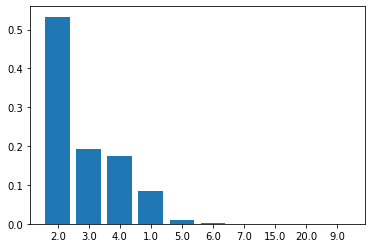

In [ ]:
# X and Y 축
## Title
font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
## Text
font_text = {
    'family': 'serif',
    'color':  'black',
    'weight': 'bold',
    'size': 10,
    }

 

def draw_barplot(feature_name, data):
  height = list(data[feature_name].value_counts(normalize = True))
  bars = tuple(data[feature_name].unique())
  x_pos = np.arange(len(bars))

  # Create bars
  plt.bar(x_pos, height)

  # Create names on the x-axis
  plt.xticks(x_pos, bars)

  # Show graph
  plt.show()
draw_barplot('family_size', features)

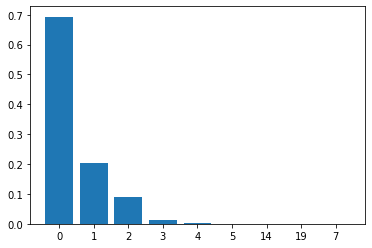

In [ ]:
draw_barplot('child_num', features)

## 카테고리형 특성 탐색
- gender
- car
- reality
- income_type
- edu_type
- familiy_type
- house_type
- occyp_type

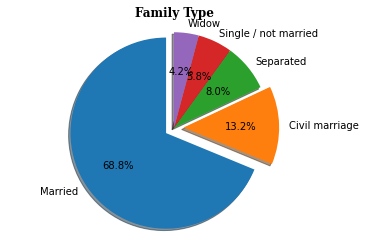

In [ ]:
def draw_pitchart(feature_name, data, title_text = ''):
  labels = list(data[feature_name].unique())
  sizes = list(data[feature_name].value_counts(normalize = True))
  range_len = len(sizes)//2
  explode = [0.1 for _ in range(range_len)] + [0 for _ in range(len(sizes) - range_len)]  # only "explode" the 1st and 2nd slice

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(title_text, fontdict = font_title)
  plt.show()
draw_pitchart('family_type', features, title_text = 'Family Type')

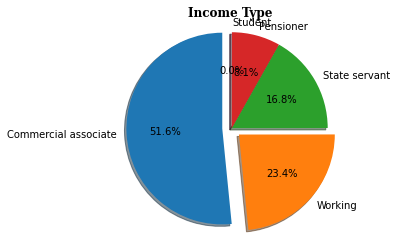

In [ ]:
# features['income_type'].value_counts(normalize = True)
draw_pitchart('income_type', features, title_text = 'Income Type')

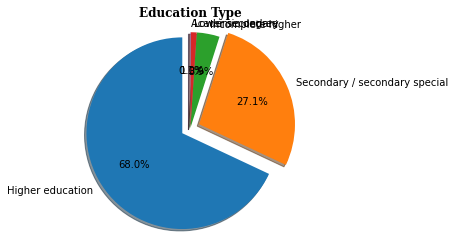

In [ ]:
draw_pitchart('edu_type', features, title_text = 'Education Type')

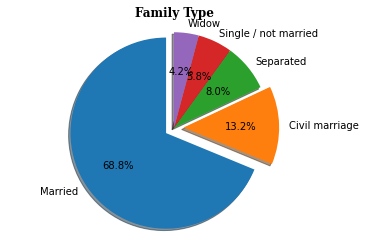

In [ ]:
draw_pitchart('family_type', features, title_text = 'Family Type')

In [ ]:
features['house_type'].value_counts(normalize = True) * 100

House / apartment      89.401671
With parents            4.751106
Municipal apartment     3.091809
Rented apartment        1.621499
Office apartment        0.718146
Co-op apartment         0.415769
Name: house_type, dtype: float64

In [ ]:
features['occyp_type'].value_counts(normalize = True) * 100
# draw_pitchart('occyp_type', features, title_text = 'Family Type')

No info                  30.884076
Laborers                 17.054088
Core staff               10.001134
Sales staff               9.596704
Managers                  8.190649
Drivers                   5.953056
High skill tech staff     3.930907
Accountants               3.409306
Medicine staff            3.265676
Cooking staff             1.727331
Security staff            1.602600
Cleaning staff            1.523226
Private service staff     0.918471
Low-skill Laborers        0.480024
Waiters/barmen staff      0.468685
Secretaries               0.366633
Realty agents             0.238122
HR staff                  0.234343
IT staff                  0.154968
Name: occyp_type, dtype: float64

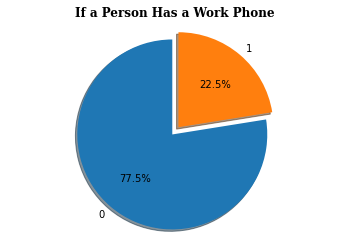

In [ ]:
draw_pitchart('work_phone', features, title_text = 'If a Person Has a Work Phone')

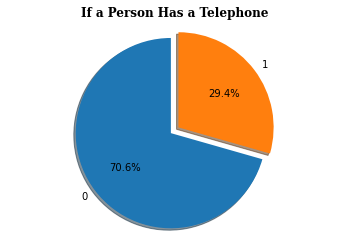

In [ ]:
draw_pitchart('phone', features, title_text = 'If a Person Has a Telephone')

In [ ]:
phone_col = ['work_phone','phone']
features[phone_col].corr()

,work_phone,phone
work_phone,1.000000,0.310256
phone,0.310256,1.000000


# Feature Engineering

2. 수입 중 outlier 확인
3. family_size 7 이상인 사람 의심
4. income_total/family_size
5. family_size - child_num
6. 법정 최저생계비 - 1인: 1096699 2인: 1852847 3인: 2390370, 4: 2925774 5인 가구: 3454424 6인 3977162 7인 4498319
   (2021년도 기준 중위소득 및 최저생계비 보건복지부 고시 제 2020-170호)
7. family_size - child_num 이 결혼시 2인 초과일때(조부모?), 미혼시 1인 초과일때(부모?)
8. 출생일 -  고용일 : 고용전 일
9. 고용일 - 카드 가입일 : 고용 이후 가입날짜
10. 모든 시간요소에 월, 주 추가

## 자녀 수가 5 이상인 경우

In [ ]:
# # 자녀 수가 5 이상인 경우, 가족규모에서 자녀수를 빼고 자녀수 0으로 치환
# cond_child = (features['child_num'] > 5)
# features.loc[cond_child, 'family_size'] -= features.loc[cond_child,'child_num']
# features.loc[cond_child,'child_num'] = 0

# print("자녀 수 현황: {0}\n가족규모 현황: {1}".format(set(features['child_num']), set(features['family_size'])))


In [ ]:
# # 카드 발급날짜
# ## 음수를 양수로 전환
# features['begin_month']  = features['begin_month'].apply(lambda x: -1 * x if x < 0 else 0)
# ## 년도, 월
# features['begin_year'] = np.floor(features['begin_month'] / 12)
# features['begin_month'] = np.floor( features['begin_month'] - features['begin_year']*12 )

# # 출생날짜 
# ## 음수를 양수로 전환
# features['DAYS_BIRTH'] = features['DAYS_BIRTH'].apply(lambda x: -1 * x)
# ## 나이
# features['age'] = features['DAYS_BIRTH'].apply(lambda x: round(x/365, 2))
# ## 년도, 월, 주
# features['Year_birth'] = np.floor(features['DAYS_BIRTH'] /365)
# features['Month_birth'] = np.floor(features['DAYS_BIRTH']/30) - np.floor(features['Year_birth']*12)
# features['Weeks_birth'] = features['DAYS_BIRTH'].apply(lambda x: x % 4)

# # 근속날짜
# ## 음수를 양수로 전환
# features['DAYS_EMPLOYED'] = features['DAYS_EMPLOYED'].apply(lambda x: -1 * x if x < 0 else 0)
# ## 근속 년도, 월, 주
# features['Year_Employed'] = features['DAYS_EMPLOYED'].apply(lambda x: np.floor(x/365) if x > 0 else 0)
# features['Month_Employed'] = np.floor(features['DAYS_EMPLOYED'] / 30) - np.floor(features['Year_Employed']*12 )
# features['Week_Employed'] = features['DAYS_EMPLOYED'].apply(lambda x: x % 4)

# # Before Employed (month and weeks)
# features['before_employed_months'] = features['Month_birth'] - features['Month_Employed']
# # features['before_employed_months'] = features.apply(lambda x: x['before_employed_months'] if x['DAYS_EMPLOYED'] > 0 else 0)

# features['before_employed_weeks'] = features['Weeks_birth'] - features['Week_Employed']
# # features['before_employed_weeks'] = features[['week_employed','before_employed_weeks']].apply(lambda x, y: y if x > 0 else 0)

# # 고용 후 발급날짜 차이
# features['diff_employed_begin_year'] = features['Year_Employed'] - features['begin_year']
# features['diff_employed_begin_month'] = features['Month_Employed'] - features['begin_month']


# # 부양가족 당 수입비율
# features['income_family_ratio'] = features['income_total']/features['family_size']

# # 자녀 외 부양가족 수
# features['family_w/o_child_size'] = features['family_size'] - features['child_num']
# cond = (features['family_w/o_child_size'] < 0) # 0 보다 작은 수를 0으로 치환
# features.loc[cond, 'family_w/o_child_size'] = 0


In [ ]:
features.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,No info,2.0,-6.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0


## Family type
미혼 / 비혼 / 이혼 으로 큰 카테고리 필

In [ ]:
features['family_type'].value_counts(normalize = True)

Married                 0.687757
Single / not married    0.132139
Civil marriage          0.080243
Separated               0.058170
Widow                   0.041690
Name: family_type, dtype: float64

In [ ]:
features['Marriage_status'] = features['family_type'].apply(lambda x: 'Marriage' if x in ['Married', 'Civil marriage'] 
                                                  else ('Was Married' if x in ['Separated', 'Widow'] else 'Single'))

features['Marriage_status'].value_counts(normalize = True)

Marriage       0.768001
Single         0.132139
Was Married    0.099860
Name: Marriage_status, dtype: float64

In [ ]:
features.groupby(by = 'family_type')[['family_size', 'child_num']].median()

# df[cond_genre].groupby(by = 'Year')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum().plot(legend = True)


,family_size,child_num
family_type,,
Civil marriage,2.0,0.0
Married,2.0,0.0
Separated,1.0,0.0
Single / not married,1.0,0.0
Widow,1.0,0.0


## income_type
student 및 비율 낮은 카테고리 조정 필


In [ ]:
features['income_type'].value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

In [ ]:
round(features.groupby(by = 'income_type')['income_total'].describe()[['mean','min','max']], 2)

,mean,min,max
income_type,,,
Commercial associate,218384.24,31500.0,1575000.0
Pensioner,149840.55,29250.0,742500.0
State servant,206126.20,32400.0,990000.0
Student,149142.86,112500.0,171000.0
Working,182445.52,27000.0,945000.0


## House / Apartment
89% 차지

In [ ]:
features['reality'].value_counts()

Y    17830
N     8627
Name: reality, dtype: int64

In [ ]:
features['house_type'].value_counts()

House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64

In [ ]:
# house_type vs reality
features.groupby(by = ['house_type', 'reality'])['gender'].count()

house_type           reality
Co-op apartment      N             44
                     Y             66
House / apartment    N           6953
                     Y          16700
Municipal apartment  N            521
                     Y            297
Office apartment     N            112
                     Y             78
Rented apartment     N            191
                     Y            238
With parents         N            806
                     Y            451
Name: gender, dtype: int64

## Occpy_type
너무 많은 카테고리 - 재조정 필


In [ ]:
features['occyp_type'].value_counts()

No info                  8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [ ]:
g_occyp_income = features.groupby(by = 'occyp_type').agg(['mean','min','max'])['income_total'].reset_index()
g_occyp_income.sort_values('max', ascending=False)

,occyp_type,mean,min,max
10,Managers,278735.249654,27000.0,1575000.0
3,Core staff,191473.629252,36000.0,990000.0
4,Drivers,210853.714286,58500.0,900000.0
6,High skill tech staff,196602.403846,63000.0,900000.0
8,Laborers,180307.189827,36000.0,900000.0
12,No info,169174.356444,29250.0,900000.0
17,Security staff,180252.594340,27000.0,810000.0
15,Sales staff,174955.579756,45000.0,697500.0
5,HR staff,186387.096774,112500.0,675000.0
0,Accountants,204651.942905,45000.0,661500.0


In [ ]:
# # 중복되는 사용자를 파악하기 위한 고유번호 
# ## 1. 나이 + 자녀수 + 연간수입 + 
# features['Unique_ID'] = features['occyp_type'].astype(str) + '_' + features['income_type'].astype(str) + '_' +\
# features['car'].astype(str) + '_' + features['child_num'].astype(str) + '_' + \
# features['edu_type'].astype(str) + '_' + features['family_size'].astype(str) + '_' + \
# features['gender'].astype(str) + '_' + features['income_total'].astype(str) + '_' +\
# features['Marriage_status'].astype(str) + '_' + features['house_type'].astype(str) + '_' + \
# features['age'].astype(str) + '_' + features['DAYS_EMPLOYED'].astype(str)


In [ ]:
# corr = features.corr()
# corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# features['Unique_ID'].head()

## 전처리 summary

In [ ]:
def preprocess_data(df):
  # 자녀 수가 5 이상인 경우, 가족규모에서 자녀수를 빼고 자녀수 0으로 치환
  cond_child = (df['child_num'] > 5)
  df.loc[cond_child, 'family_size'] -= df.loc[cond_child,'child_num']
  df.loc[cond_child,'child_num'] = 0

  # 카드 발급날짜
  ## 음수를 양수로 전환
  df['begin_month']  = df['begin_month'].apply(lambda x: -1 * x if x < 0 else 0)
  ## 년도, 월
  df['begin_year'] = df['begin_month'].apply(lambda x: x//12)
  df['begin_month'] = np.floor( df['begin_month'] - df['begin_year']*12 )

  # 출생날짜 
  ## 음수를 양수로 전환
  df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: -1 * x)
  ## 나이
  df['age'] = df['DAYS_BIRTH'].apply(lambda x: round(x/365, 2))
  ## 년도, 월, 주
  df['Year_birth'] = np.floor(df['DAYS_BIRTH'] /365)
  df['Month_birth'] = np.floor(df['DAYS_BIRTH']/30) - np.floor(df['Year_birth']*12)
  df['Weeks_birth'] = df['DAYS_BIRTH'].apply(lambda x: x % 4)

  # 근속날짜
  ## 음수를 양수로 전환
  df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: -1 * x if x < 0 else 0)
  ## 근속 년도, 월, 주
  df['Year_Employed'] = df['DAYS_EMPLOYED'].apply(lambda x: x//365 if x > 0 else 0)
  df['Month_Employed'] = (df['DAYS_EMPLOYED'] // 30) - (df['Year_Employed']*12 )
  df['Week_Employed'] = df['DAYS_EMPLOYED'].apply(lambda x: x % 4)
 
  # Before Employed (month and weeks)
  df['before_employed_months'] = df['Month_birth'] - df['Month_Employed']
  df['before_employed_weeks'] = df['Weeks_birth'] - df['Week_Employed']
  
  # 고용 후 발급날짜 차이
  df['diff_employed_begin_year'] = df['Year_Employed'] - df['begin_year']
  df['diff_employed_begin_month'] = df['Month_Employed'] - df['begin_month']


  # 부양가족 당 수입비율
  df['income_family_ratio'] = df['income_total']/df['family_size']

  # 자녀 외 부양가족 수
  df['family_w/o_child_size'] = df['family_size'] - df['child_num']
  cond = (df['family_w/o_child_size'] < 0) # 0 보다 작은 수를 0으로 치환
  df.loc[cond, 'family_w/o_child_size'] = 0

  # 결혼여부
  df['Marriage_status'] = df['family_type'].apply(lambda x: 'Marriage' if x in ['Married', 'Civil marriage'] 
                                                    else ('Was Married' if x in ['Separated', 'Widow'] else 'Single'))

  # 중복되는 사용자를 파악하기 위한 고유번호 
  ## 1. 나이 + 자녀수 + 연간수입 + 
  df['Unique_ID'] = df['occyp_type'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
  df['car'].astype(str) + '_' + df['child_num'].astype(str) + '_' + \
  df['edu_type'].astype(str) + '_' + df['family_size'].astype(str) + '_' + \
  df['gender'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
  df['Marriage_status'].astype(str) + '_' + df['house_type'].astype(str) + '_' + \
  df['age'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str)

  # 숫자로 대체 가능한 카테고리 특성 변환
  ## 교육수준 (숫자가 작을 수록 높은 학업)
  edu_ordinal = {'Academic degree': 1, 'Higher education': 2,'Incomplete higher': 3, 
                 'Secondary / secondary special': 4,'Lower secondary': 5}

  df['edu_type'] = df['edu_type'].apply(lambda x: edu_ordinal.get(x))
  ## gender(F = 1, M = 0), car(Y = 1, N = 0), reality(Y = 1, N = 0)
  df['gender'] = df['gender'].apply(lambda x: 1 if x == 'F' else 0)
  df['car'] = df['car'].apply(lambda x: 1 if x == 'Y' else 0)
  df['reality'] = df['reality'].apply(lambda x: 1 if x == 'Y' else 0)

  return df


# 모델링

In [ ]:
# Test 데이터 전처리
train_pre = preprocess_data(features)
test_pre = preprocess_data(test)

## 스케일링

In [ ]:
scal_col = ['income_total', 'income_family_ratio', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'age', 'Year_birth']
scaler = StandardScaler()
train_pre[scal_col] = scaler.fit_transform(train_pre[scal_col])
test_pre[scal_col] = scaler.transform(test_pre[scal_col])

In [ ]:
train_pre.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,Year_Employed,Month_Employed,Week_Employed,before_employed_months,before_employed_weeks,diff_employed_begin_year,diff_employed_begin_month,income_family_ratio,family_w/o_child_size,Unique_ID
0,1,0,0,0,0.149136,Commercial associate,2,Married,Municipal apartment,-0.490075,...,12,12,1,-5.0,2,12.0,6.0,0.001887,2.0,No info_Commercial associate_N_0_Higher educat...
1,1,0,1,1,0.590848,Commercial associate,4,Civil marriage,House / apartment,-1.089621,...,4,3,0,4.0,0,4.0,-2.0,-0.254319,2.0,Laborers_Commercial associate_N_1_Secondary / ...
2,0,1,1,0,2.578550,Working,2,Married,House / apartment,0.744719,...,12,3,2,9.0,1,11.0,-7.0,1.692843,2.0,Managers_Working_Y_0_Higher education_2.0_M_45...
3,1,0,1,0,0.149136,Commercial associate,4,Married,House / apartment,-0.207081,...,5,9,0,1.0,0,2.0,8.0,0.001887,2.0,Sales staff_Commercial associate_N_0_Secondary...
4,1,1,1,0,-0.292575,State servant,2,Married,House / apartment,-0.219220,...,5,10,1,-1.0,0,3.0,8.0,-0.305560,2.0,Managers_State servant_Y_0_Higher education_2....


## 인코딩


In [ ]:
# 카테고리 특성 호출
obj_col = features.dtypes[features.dtypes == 'object'].index.to_list()

In [ ]:
# 카테고리 특성 인코딩
## 인코딩 메소드 호출
encoder = TargetEncoder() 
## 인코딩 훈련 및 변환 (train, test)
train_pre[obj_col] = encoder.fit_transform(train_pre[obj_col], target) 
test_pre[obj_col] = encoder.transform(test_pre[obj_col])

In [ ]:
# train, test 분리하기
X_train, X_val, y_train, y_val = train_test_split(train_pre, target, test_size = 0.2, stratify = target)
X_train.shape, y_train.shape

((21165, 33), (21165,))

In [ ]:
X_train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,Year_Employed,Month_Employed,Week_Employed,before_employed_months,before_employed_weeks,diff_employed_begin_year,diff_employed_begin_month,income_family_ratio,family_w/o_child_size,Unique_ID
23977,1,0,1,0,-0.734287,1.526927,4,1.529237,1.521625,0.365332,...,10,3,2,16.0,-1,6.0,3.0,-0.613007,2.0,1.996784
25681,1,0,0,0,-1.131827,1.531119,4,1.529237,1.510740,-1.605864,...,3,1,3,6.0,0,2.0,-3.0,-0.889709,2.0,1.649131
5689,1,1,1,0,0.369992,1.515397,4,1.501144,1.521625,1.413051,...,0,0,0,21.0,3,0.0,-7.0,1.692843,1.0,1.139731
17670,1,0,1,0,-0.822629,1.514474,4,1.474800,1.521625,1.333079,...,11,9,2,1.0,1,11.0,1.0,-0.674496,2.0,0.408673
16875,1,0,1,0,-0.292575,1.531119,4,1.529237,1.521625,0.153979,...,3,9,3,4.0,-2,-1.0,2.0,-0.305560,2.0,1.942730


In [ ]:
y_train.value_counts()

2.0    13574
1.0     5013
0.0     2578
Name: credit, dtype: int64

## Logistic Regression

In [ ]:
# Logistic 모델 메소드 호출 및 훈련
## newton-cg L2 패널티
mod_logistic = LogisticRegressionCV(random_state = 42, cv = 5, multi_class = 'multinomial')
mod_logistic.fit(X_train, y_train)  

# prediction
y_pred_val = mod_logistic.predict(X_val)
y_pred_train = mod_logistic.predict(X_train)

# 다중클래스 roc_auc_score 구하기 전 사전 작업
## 라벨링 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
## prediction
y_pred_val = label_binarize(y_pred_val, classes=labels)
y_pred_train = label_binarize(y_pred_train, classes=labels)
## true value
y_val_binarize = label_binarize(y_val, classes = labels)
y_train_binarize = label_binarize(y_train, classes = labels)


# Unlike 'ovr', 'ovo' is insensitive to class imbalance
logistic_score_train = roc_auc_score(y_pred_train, y_train_binarize, average='macro',multi_class='ovo')
logistic_score_val = roc_auc_score(y_pred_val, y_val_binarize, average='macro',multi_class='ovo')

print("------------------------------------------------")
print("------Roc-Auc Curve-----")
print("Train:", logistic_score_train)
print("Validation:", logistic_score_val)

------------------------------------------------
------Roc-Auc Curve-----
Train: 0.7722021340783759
Validation: 0.7751509970022467


In [ ]:
target.value_counts(normalize = True)

2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: credit, dtype: float64

In [ ]:
y_pred_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

## Random Forest

In [ ]:
# pipe_rf = make_pipeline(
#                         RandomForestClassifier(n_estimators = 500, class_weight='balanced')
#                         )

# param_dict = {
#     "randomforestclassifier__max_depth": randint(10, 50),
#     'randomforestclassifier__max_features': uniform(0,1),
#     'randomforestclassifier__min_samples_split': randint(10, 50),
#     'randomforestclassifier__min_samples_leaf': randint(10, 50),
# }
            
# random_grid_rf = RandomizedSearchCV(pipe_rf,
#                                  param_distributions = param_dict,
#                                  n_iter = 100,
#                                  scoring = 'roc_auc_ovo',
#                                  random_state = 42,
#                                  cv = 3,
#                                  verbose = 1,
#                                  n_jobs = -1
#                                  )
# random_grid_rf.fit(X_train, y_train)
# print("Best parameter:",random_grid_rf.best_params_)
# print('Roc-Auc Curve: ', random_grid_rf.best_score_)

# # ---------------------------scoring -------------------------#

# # The best Random Forest Model
# best_rf = random_grid_rf.best_estimator_

# # ROC-AUC Curve / ROC Curve
# y_pred_val_rf = best_rf.predict(X_val)
# y_pred_train_rf = best_rf.predict(X_train)

# ## binarize for multiclasses
# y_pred_val_rf_binarize = label_binarize(y_pred_val_rf,  classes = labels)
# y_pred_train_rf_binarize = label_binarize(y_pred_train_rf, classes = labels)

# ## true value
# y_val_binarize = label_binarize(y_val, classes = labels)
# y_train_binarize = label_binarize(y_train, classes = labels)


# rf_score_train = roc_auc_score(y_pred_train_rf, y_train_binarize, average='macro',multi_class='ovo')
# rf_score_val = roc_auc_score(y_pred_val_rf_binarize, y_val_binarize, average='macro',multi_class='ovo')

# print("------------------------------------------------")
# print("------Roc-Auc Curve-----")
# print("Train:", rf_score_train)
# print("Validation:", rf_score_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameter: {'randomforestclassifier__max_depth': 48, 'randomforestclassifier__max_features': 0.906828441545754, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__min_samples_split': 36}
Roc-Auc Curve:  0.8548107056079096
------------------------------------------------
------Roc-Auc Curve-----
Train: 0.8089594619338359
Validation: 0.7336512526845212


Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameter: {'randomforestclassifier__max_depth': 48, 'randomforestclassifier__max_features': 0.906828441545754, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__min_samples_split': 36}

Roc-Auc Curve:  0.8548107056079096

------Roc-Auc Curve-----

Train: 0.8089594619338359

Validation: 0.7336512526845212

In [ ]:
# Best Random Forest Model
best_rf = RandomForestClassifier(n_estimators = 500, class_weight='balanced',
                                     max_depth =  48, max_features = 0.9068, 
                                     min_samples_leaf= 10, min_samples_split= 36)
# Fit the model
best_rf.fit(X_train, y_train)
# Prediction
y_pred_val_rf = best_rf.predict(X_val)
y_pred_train_rf = best_rf.predict(X_train)
y_pred_train_rf

array([2., 1., 2., ..., 2., 2., 2.])

## XGBoost

In [ ]:
# from xgboost import XGBClassifier
# pipe_xgb = make_pipeline(
#                         XGBClassifier(objective = 'multi:softmax', 
#                                       n_estimators = 500,
#                                       seed = 42,
#                                       eval_metric = 'mlogloss')
#                         )

# param_dict = {
#     "xgbclassifier__max_depth": randint(1,10),
#     'xgbclassifier__min_child_weight': randint(10, 20),
#     'xgbclassifier__gamma': uniform(0,1),
#     'xgbclassifier__subsample': [0.5,0.6,0.7,0.8,0.9],
#     'xgbclassifier__colsample_bytree': [0.5,0.6,0.7,0.8,0.9],
#     'xgbclassifier__learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1]
# }
            
# random_grid_xgb = RandomizedSearchCV(pipe_xgb,
#                                  param_distributions = param_dict,
#                                  n_iter = 200,
#                                  scoring = 'roc_auc_ovo',
#                                  random_state = 42,
#                                  cv = 3,
#                                  verbose = 1,
#                                  n_jobs = -1
#                                  )
# random_grid_xgb.fit(X_train, y_train)
# print("Best parameter:",random_grid_xgb.best_params_)
# print('Roc-Auc Curve: ', random_grid_xgb.best_score_)

# # ---------------------------scoring -------------------------#

# # The best Random Forest Model
# best_xgb = random_grid_xgb.best_estimator_

# # ROC-AUC Curve / ROC Curve
# y_pred_val_xgb = best_xgb.predict(X_val)
# y_pred_train_xgb = best_xgb.predict(X_train)

# ## binarize for multiclasses
# y_pred_val_xgb_binarize = label_binarize(y_pred_val_xgb, classes = labels)
# y_pred_train_xgb_binarize = label_binarize(y_pred_train_xgb, classes = labels)


# ## true value
# y_val_binarize = label_binarize(y_val, classes = labels)
# y_train_binarize = label_binarize(y_train, classes = labels)

# # Input binarized both prediction and true values
# xgb_score_train = roc_auc_score(y_pred_train_xgb_binarize, y_train_binarize, average='macro',multi_class='ovo')
# xgb_score_val = roc_auc_score(y_pred_val_xgb_binarize, y_val_binarize, average='macro',multi_class='ovo')

# print("------------------------------------------------")
# print("------Roc-Auc Curve-----")
# print("Train:", xgb_score_train)
# print("Validation:", xgb_score_val)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameter: {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0.37772888617629485, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 18, 'xgbclassifier__subsample': 0.9}
Roc-Auc Curve:  0.8451775905260931
------------------------------------------------
------Roc-Auc Curve-----
Train: 0.8233626446548897
Validation: 0.7899040586521631


- best result 

Fitting 3 folds for each of 200 candidates, totalling 600 fits

Best parameter: {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0.37772888617629485, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 18, 'xgbclassifier__subsample': 0.9}

Roc-Auc Curve:  0.8451775905260931

------Roc-Auc Curve-----

Train: 0.8233626446548897

Validation: 0.7899040586521631

In [ ]:
from xgboost import XGBClassifier
# Best XGBoost
best_xgb = XGBClassifier(objective = 'multi:softmax', n_estimators = 500,
                         seed = 42,eval_metric = 'mlogloss',
                         colsample_bytree = 0.5, gamma = 0.3777, learning_rate = 0.05,
                         max_depth = 4, min_child_weight = 18, subsample = 0.9)

# Fit the model
best_xgb.fit(X_train, y_train)
# prediction
y_pred_val_xgb = best_xgb.predict(X_val)
y_pred_train_xgb = best_xgb.predict(X_train)
y_pred_train_xgb

array([2., 2., 2., ..., 2., 2., 2.])

## LightGBM


In [ ]:
# from lightgbm import LGBMClassifier
# pipe_lgbm = make_pipeline(
#                         LGBMClassifier(random_state=42, 
#                                        silent=True, 
#                                        metric='multi_logloss',
#                                        objective= 'multiclass',
#                                        n_jobs=-1, 
#                                        n_estimators=500)
#                         )



 

# parameters ={'lgbmclassifier__num_leaves': randint(6, 50), 
#              'lgbmclassifier__min_child_samples': randint(100, 500), 
#              'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'lgbmclassifier__subsample': uniform(loc=0.2, scale=0.8), 
#              'lgbmclassifier__colsample_bytree': uniform(loc=0.4, scale=0.6),
#              'lgbmclassifier__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'lgbmclassifier__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
#              'lgbmclassifier__learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1]
#             }



# random_grid_lgbm = RandomizedSearchCV(pipe_lgbm,
#                                  param_distributions = parameters,
#                                  n_iter = 200,
#                                  scoring = 'roc_auc_ovo',
#                                  random_state = 42,
#                                  cv = 3,
#                                  verbose = 1,
#                                  n_jobs = -1,  
#                                  )


# random_grid_lgbm.fit(X_train, y_train)
# print("Best parameter:",random_grid_lgbm.best_params_)
# print('Roc-Auc Curve: ', random_grid_lgbm.best_score_)
# # The best Random Forest Model
# best_lgbm = random_grid_lgbm.best_estimator_

# # ROC-AUC Curve / ROC Curve
# y_pred_val_lgbm = best_lgbm.predict(X_val)
# y_pred_train_lgbm = best_lgbm.predict(X_train)


# ## binarize for multiclasses
# y_pred_val_lgbm_binarize = label_binarize(y_pred_val_lgbm, classes = labels)
# y_pred_train_lgbm_binarize = label_binarize(y_pred_train_lgbm, classes = labels)


# ## true value
# y_val_binarize = label_binarize(y_val, classes = labels)
# y_train_binarize = label_binarize(y_train, classes = labels)


# lgbm_score_train = roc_auc_score(y_pred_train_lgbm_binarize, y_train_binarize, average='macro',multi_class='ovo')
# lgbm_score_val = roc_auc_score(y_pred_val_lgbm_binarize, y_val_binarize, average='macro',multi_class='ovo')

# print("------------------------------------------------")
# print("------Roc-Auc Curve-----")
# print("Train:", lgbm_score_train)
# print("Validation:", lgbm_score_val)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameter: {'lgbmclassifier__colsample_bytree': 0.5174746808735778, 'lgbmclassifier__learning_rate': 0.09, 'lgbmclassifier__min_child_samples': 111, 'lgbmclassifier__min_child_weight': 0.001, 'lgbmclassifier__num_leaves': 40, 'lgbmclassifier__reg_alpha': 10, 'lgbmclassifier__reg_lambda': 0, 'lgbmclassifier__subsample': 0.7245781083045937}
Roc-Auc Curve:  0.8475192164863617
------------------------------------------------
------Roc-Auc Curve-----
Train: 0.8286943386897354
Validation: 0.7903070386851737


- best result

Fitting 3 folds for each of 200 candidates, totalling 600 fits

Best parameter: {'lgbmclassifier__colsample_bytree': 0.5174746808735778, 'lgbmclassifier__learning_rate': 0.09, 'lgbmclassifier__min_child_samples': 111, 'lgbmclassifier__min_child_weight': 0.001, 'lgbmclassifier__num_leaves': 40, 'lgbmclassifier__reg_alpha': 10, 'lgbmclassifier__reg_lambda': 0, 'lgbmclassifier__subsample': 0.7245781083045937}

Roc-Auc Curve:  0.8475192164863617

------Roc-Auc Curve-----

Train: 0.8286943386897354

Validation: 0.7903070386851737

In [ ]:
from lightgbm import LGBMClassifier
best_lgbm = LGBMClassifier(random_state=42, silent=True, 
                           metric='multi_logloss', objective= 'multiclass',
                           n_jobs=-1, n_estimators=500,
                           colsample_bytree=0.5175, learning_rate = 0.09,
                           min_child_samples= 111, min_child_weight= 0.001,
                           num_leaves = 40, reg_alpha=10, reg_lambda=0,subsample = 0.7246)
# Fit the model
best_lgbm.fit(X_train, y_train)
#Prediction
y_pred_val_lgbm = best_lgbm.predict(X_val)
y_pred_train_lgbm = best_lgbm.predict(X_train)
y_pred_train_lgbm

array([2., 2., 2., ..., 2., 2., 2.])

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

## CatBoost

In [ ]:
# from catboost import Pool, CatBoostClassifier

# pipe_cb = make_pipeline(
#                         CatBoostClassifier(
#                                       iterations = 500,
#                                       random_seed = 42,
#                                       l2_leaf_reg = 1,
#                                       eval_metric = 'MultiClass')
#                         )

# param_dict = {
#     "catboostclassifier__learning_rate": [0.1, 0.05, 0.03, 0.01],
#     'catboostclassifier__max_depth': randint(1, 16),
#     'catboostclassifier__rsm': uniform(loc=0.2, scale=0.8),
#     'catboostclassifier__ignored_features': randint(1,5)
# }
            
# random_grid_cb = RandomizedSearchCV(pipe_cb,
#                                  param_distributions = param_dict,
#                                  n_iter = 50,
#                                  scoring = 'roc_auc_ovo',
#                                  random_state = 42,
#                                  cv = 3,
#                                  verbose = 1,
#                                  n_jobs = -1
#                                  )
# random_grid_cb.fit(X_train, y_train)
# print("Best parameter:",random_grid_cb.best_params_)
# print('Roc-Auc Curve: ', random_grid_cb.best_score_)

# # ---------------------------scoring -------------------------#

# # The best Random Forest Model
# best_cb = random_grid_cb.best_estimator_

# # ROC-AUC Curve / ROC Curve
# y_pred_val_cb = best_cb.predict(X_val)
# y_pred_train_cb = best_cb.predict(X_train)

# ## binarize for multiclasses
# y_pred_val_cb_binarize = label_binarize(y_pred_val_cb, classes = labels)
# y_pred_train_cb_binarize = label_binarize(y_pred_train_cb, classes = labels)


# ## true value
# y_val_binarize = label_binarize(y_val, classes = labels)
# y_train_binarize = label_binarize(y_train, classes = labels)

# # Input binarized both prediction and true values
# cb_score_train = roc_auc_score(y_pred_train_cb_binarize, y_train_binarize, average='macro',multi_class='ovo')
# cb_score_val = roc_auc_score(y_pred_val_cb_binarize, y_val_binarize, average='macro',multi_class='ovo')

# print("------------------------------------------------")
# print("------Roc-Auc Curve-----")
# print("Train:", cb_score_train)
# print("Validation:", cb_score_val)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
52:	learn: 0.5845649	total: 1m 47s	remaining: 15m 8s
53:	learn: 0.5810458	total: 1m 48s	remaining: 14m 58s
54:	learn: 0.5774544	total: 1m 49s	remaining: 14m 49s
55:	learn: 0.5738000	total: 1m 52s	remaining: 14m 48s
56:	learn: 0.5710895	total: 1m 54s	remaining: 14m 49s
57:	learn: 0.5678766	total: 1m 56s	remaining: 14m 49s
58:	learn: 0.5655211	total: 1m 59s	remaining: 14m 49s
59:	learn: 0.5624526	total: 2m	remaining: 14m 41s
60:	learn: 0.5597770	total: 2m 1s	remaining: 14m 35s
61:	learn: 0.5568225	total: 2m 4s	remaining: 14m 36s
62:	learn: 0.5545563	total: 2m 6s	remaining: 14m 40s
63:	learn: 0.5516922	total: 2m 8s	remaining: 14m 36s
64:	learn: 0.5487029	total: 2m 10s	remaining: 14m 30s
65:	learn: 0.5457179	total: 2m 12s	remaining: 14m 29s
66:	learn: 0.5434041	total: 2m 14s	remaining: 14m 30s
67:	learn: 0.5409626	total: 2m 16s	remaining: 14m 26s
68:	learn: 0.5390206	total: 2m 18s	remaining: 14m 23s
69:	learn: 0.5362104	total: 2m 19s	remaining: 14m 14s
7

Best parameter: {'catboostclassifier__ignored_features': 4, 'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__max_depth': 3, 'catboostclassifier__rsm': 0.6730382301661817}

Roc-Auc Curve:  0.844780026616883

------Roc-Auc Curve-----

Train: 0.811514259071978

Validation: 0.7915215455824257

In [ ]:
from catboost import Pool, CatBoostClassifier
best_cb = CatBoostClassifier(iterations = 500,random_seed = 42,
                   l2_leaf_reg = 1,eval_metric = 'MultiClass',
                   ignored_features=4, learning_rate = 0.1,
                   max_depth=3, rsm = 0.673)
# Fit the model
best_cb.fit(X_train, y_train)
#Prediction
y_pred_val_cb = best_cb.predict(X_val)
y_pred_train_cb = best_cb.predict(X_train)
y_pred_train_cb.reshape(1,-1)[0]       

0:	learn: 1.0150514	total: 19.4ms	remaining: 9.69s
1:	learn: 0.9701106	total: 31.4ms	remaining: 7.83s
2:	learn: 0.9194672	total: 44.4ms	remaining: 7.35s
3:	learn: 0.8716321	total: 59.3ms	remaining: 7.36s
4:	learn: 0.8350299	total: 75.3ms	remaining: 7.46s
5:	learn: 0.8104407	total: 101ms	remaining: 8.36s
6:	learn: 0.7835896	total: 113ms	remaining: 7.96s
7:	learn: 0.7595330	total: 126ms	remaining: 7.72s
8:	learn: 0.7389563	total: 135ms	remaining: 7.37s
9:	learn: 0.7249687	total: 146ms	remaining: 7.14s
10:	learn: 0.7062280	total: 155ms	remaining: 6.88s
11:	learn: 0.6921695	total: 172ms	remaining: 6.98s
12:	learn: 0.6810429	total: 181ms	remaining: 6.79s
13:	learn: 0.6692555	total: 190ms	remaining: 6.6s
14:	learn: 0.6584300	total: 198ms	remaining: 6.39s
15:	learn: 0.6508498	total: 208ms	remaining: 6.3s
16:	learn: 0.6419145	total: 216ms	remaining: 6.13s
17:	learn: 0.6345747	total: 222ms	remaining: 5.96s
18:	learn: 0.6287131	total: 230ms	remaining: 5.82s
19:	learn: 0.6243371	total: 239ms	rema

array([[2.],
       [2.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]])

## Stacking Ensemble

In [ ]:
from numpy import mean, std
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# # 기본모델에서 얻은 예측값을 새로운 데이터로 변환
# def get_models():
#   models = dict()
#   models['logistic'] = mod_logistic
#   models['rf'] = best_rf
#   models['xgb'] = best_xgb
#   models['lgbm'] = best_lgbm
#   models['cb'] = best_cb
#   return models

# def eval_model(model, x, y):
#   cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
#   scores = cross_val_score(model, x, y, scoring = 'neg_log_loss', cv = cv, n_jobs = -1, error_score='raise')
#   return scores

# # Get all the best models
# models = get_models()
# # Evaluate models 
# results, names = list(), list()
# for name, model in models.items():
#   scores = eval_model(model, X_train, y_train)
#   results.append(scores)
#   names.append(name)
#   print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# # plot model performance
# plt.boxplot(results, lables = names, showmeans = True)
# plt.show()

In [ ]:
# from sklearn.ensemble import StackingClassifier
# # base models
# layer0 = list()
# layer0.append( ('logistic', mod_logistic) )
# layer0.append( ('ft', best_rf) )
# layer0.append( ('xgb', best_xgb) )
# layer0.append( ('lgbm', best_lgbm) )
# layer0.append( ('catboost', best_cb) )
# # Final model (lgbm)
# layer1 = LGBMClassifier(random_state=42, silent=True, 
#                         metric='multi_logloss',
#                         objective= 'multiclass',
#                         n_jobs=-1, 
#                         n_estimators=500)
# # Stacking ensemble
# stacking_mod = StackingClassifier(estimators = layer0, 
#                                   final_estimator = layer1,
#                                   cv = 5, n_jobs = -1)
# # Training
# stacking_mod.fit(X_train, y_train)
# stacking_mod.score(X_val, y_val)

/Users/xper100/opt/anaconda3/envs/project1/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 1.0145731	total: 23.2ms	remaining: 11.6s
0:	learn: 1.0153194	total: 70.4ms	remaining: 35.1s
0:	learn: 1.0143487	total: 69ms	remaining: 34.4s
1:	learn: 0.9699579	total: 97.9ms	remaining: 24.4s
2:	learn: 0.9196532	total: 118ms	remaining: 19.6s
0:	learn: 1.0139567	total: 164ms	remaining: 1m 21s
1:	learn: 0.9487355	total: 182ms	remaining: 45.4s
0:	learn: 1.0151546	total: 19.6ms	remaining: 9.76s
1:	learn: 0.9702265	total: 45.3ms	remaining: 11.3s
1:	learn: 0.9690322	total: 189ms	remaining: 47.2s
1:	learn: 0.9690323	total: 209ms	remaining: 52.1s
3:	learn: 0.8724394	total: 224ms	remaining: 27.8s
2:	learn: 0.9198614	total: 65.9ms	remaining: 10.9s
2:	learn: 0.9182536	total: 226ms	remaining: 37.4s
2:	learn: 0.8962779	total: 379ms	remaining: 1m 2s
2:	learn: 0.9168457	total: 312ms	remaining: 51.7s
3:	learn: 0.8547590	total: 399ms	remaining: 49.5s
4:	learn: 0.8364148	total: 355ms	remaining: 35.2s
3:	learn: 0.8700540	total: 351ms	remaining: 43.5s
3:	learn: 0.8705045	total: 342ms	remaining: 

/Users/xper100/opt/anaconda3/envs/project1/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xper100/opt/anaconda3/envs/project1/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

0.7753212396069539

In [ ]:
# # ROC-AUC Curve / ROC Curve
# y_pred_val_stack = stacking_mod.predict(X_val)
# y_pred_train_stack = stacking_mod.predict(X_train)


# ## binarize for multiclasses
# y_pred_val_stack_binarize = label_binarize(y_pred_val_stack, classes = labels)
# y_pred_train_stack_binarize = label_binarize(y_pred_train_stack, classes = labels)


# ## true value
# y_val_binarize = label_binarize(y_val, classes = labels)
# y_train_binarize = label_binarize(y_train, classes = labels)


# stack_score_train = roc_auc_score(y_pred_train_stack_binarize, y_train_binarize, average='macro',multi_class='ovo')
# stack_score_val = roc_auc_score(y_pred_val_stack_binarize, y_val_binarize, average='macro',multi_class='ovo')

# print("------------------------------------------------")
# print("------Roc-Auc Curve-----")
# print("Train:", stack_score_train)
# print("Validation:", stack_score_val)

------------------------------------------------
------Roc-Auc Curve-----
Train: 0.8047815176363663
Validation: 0.7887916779566334



------Roc-Auc Curve-----

Train: 0.8047815176363663

Validation: 0.7887916779566334

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

## Neural Network

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, Flatten, BatchNormalization,Attention
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
tf.random.set_seed(42)